In [4]:
import sys
sys.path.append('../') # make modules visible to each other
import pandas as pd
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np
import yaml
from src.data.split_dataset import splitDataset
import warnings
warnings.filterwarnings("ignore")

In [13]:
with open("../src/CONFIG.yaml", 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
    filepaths = config['filepaths']
input_filepath = filepaths['input_filepath']
processed_filepath = filepaths['processed_filepath']
encoded_filepath = filepaths['encoded_filepath']

data = pd.read_csv('../' + encoded_filepath)
data['Date'] = pd.to_datetime(data['Date'])
split_dataset = splitDataset(data,scale = True)
X_train, y_train, X_test, y_test, actuals, train_date, test_date = split_dataset.run()

xgb_model = XGBRegressor()

param_grid = {
    'learning_rate': [0.1, 0.2, 0.7],
    'n_estimators': [100, 110, 150],
    'max_depth': [5,7,9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = np.exp(best_model.predict(X_test))

# Evaluate the model
def wmape(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)

print("WMAPE:", wmape(actuals, y_pred))

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
WMAPE: 0.1191860408360553


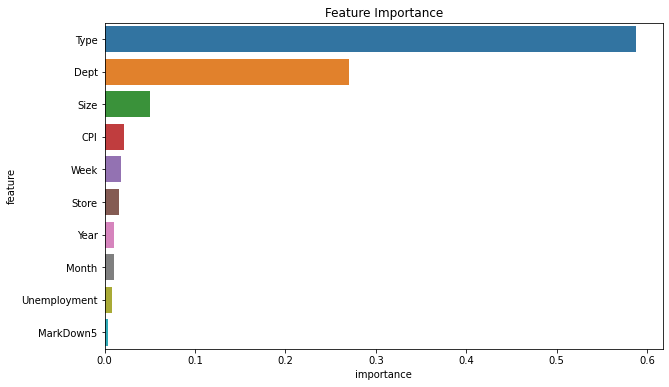

In [15]:
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance':best_model.feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');